# Implementation of new curtailment constraints in MESSAGEix-GLOBIOM

Load modules:

In [210]:
import message_ix
import ixmp as ix
from message_ix.utils import make_df
from itertools import product
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [211]:
replace_stor_ppl = False
keep_curtailment = True

### Steps taken:
1. Read curtailment parameters derived from PyPSA-Eur
2. Load scenario in MESSAGEix-GLOBIOM
3. Convert retained technology contributions to new data structure
4. Technology linkage (adding SDES and LDES)
5. Add curtailment technologies and relations to the scenario
6. Solve scenario

### Step 1) fetch curtailment parameters

Read parameters derived from PyPSA-Eur scenarios and collect them in dictionaries:

In [238]:
# gamma coefficients (marginal curtailment rates)
path = "parameters/"
gamma_ij_wind = pd.read_csv(path + "gamma_ij_wind_primary.csv",index_col=0).dropna()
gamma_ij_solar = pd.read_csv(path + "gamma_ij_solar_primary.csv",index_col=0).dropna()

# beta coefficients (counter acting term from renewable integration support measures)
techs = ["LDES","SDES"] # technologies for which coefficients are fetched from PyPSA-Eur scenarios
beta_tech_wind = {}
beta_tech_solar = {}
beta_tech_aggr = {}
for tech in techs:
    df_read_w = pd.read_csv(path + "beta_"+tech+"_wind.csv",index_col=0).dropna()
    df_read_s = pd.read_csv(path + "beta_"+tech+"_solar.csv",index_col=0).dropna()

    df_read_w.loc["wind_curtailment_w0s0"] = df_read_w.loc["wind_curtailment_w1s0"]
    df_read_w.loc["wind_curtailment_w1s0"] = 0

    df_read_s.loc["solar_curtailment_s0w0"] = df_read_s.loc["solar_curtailment_s1w0"]
    df_read_s.loc["solar_curtailment_s1w0"] = 0

    beta_tech_wind[tech] = df_read_w
    beta_tech_solar[tech] = df_read_s

# renewable shares
wind_shares_pypsa = pd.read_csv(path + "wind_shares.csv",index_col=0).loc[gamma_ij_wind.index]
solar_shares_pypsa = pd.read_csv(path + "solar_shares.csv",index_col=0).loc[gamma_ij_solar.index]

# create dictionaries that contain the parameters
gamma_dict = gamma_ij_solar.to_dict()["0"]
gamma_wind_dict = gamma_ij_wind.to_dict()["0"]
gamma_dict.update(gamma_wind_dict) # dictionary containing all gamma coefficients

renewable_penetration_dict = solar_shares_pypsa.to_dict()["0"]
wind_penetration = wind_shares_pypsa.to_dict()["0"]
renewable_penetration_dict.update(wind_penetration)

In [213]:
df_beta_solar = beta_tech_solar["LDES"].copy()
df_beta_solar["ind"] = df_beta_solar.index
df_beta_solar["ind"] = df_beta_solar.ind.str.split("_",expand=True)[2]
df_beta_solar["solar"] = df_beta_solar["ind"].str.split("s",expand=True)[1].str.split("w",expand=True)[0]
df_beta_solar["wind"] = df_beta_solar["ind"].str.split("s",expand=True)[1].str.split("w",expand=True)[1]
df_beta_solar = df_beta_solar.set_index(["solar","wind"])["0"]
df_beta_solar = df_beta_solar.unstack().sort_index(ascending=False)
df_beta_solar_LDES = df_beta_solar.round(3).copy()

df_beta_solar = beta_tech_solar["SDES"].copy()
df_beta_solar["ind"] = df_beta_solar.index
df_beta_solar["ind"] = df_beta_solar.ind.str.split("_",expand=True)[2]
df_beta_solar["solar"] = df_beta_solar["ind"].str.split("s",expand=True)[1].str.split("w",expand=True)[0]
df_beta_solar["wind"] = df_beta_solar["ind"].str.split("s",expand=True)[1].str.split("w",expand=True)[1]
df_beta_solar = df_beta_solar.set_index(["solar","wind"])["0"]
df_beta_solar = df_beta_solar.unstack().sort_index(ascending=False)
df_beta_solar_SDES = df_beta_solar.round(3).copy()

In [214]:
df_beta_wind = beta_tech_wind["LDES"].copy()
df_beta_wind["ind"] = df_beta_wind.index
df_beta_wind["ind"] = df_beta_wind.ind.str.split("_",expand=True)[2]
df_beta_wind["solar"] = df_beta_wind["ind"].str.split("s",expand=True)[1]
df_beta_wind["wind"] = df_beta_wind["ind"].str.split("s",expand=True)[0].str.split("w",expand=True)[1]
df_beta_wind = df_beta_wind.set_index(["solar","wind"])["0"]
df_beta_wind = df_beta_wind.unstack().sort_index(ascending=False)
df_beta_wind_LDES = df_beta_wind.round(3).copy()

df_beta_wind = beta_tech_wind["SDES"].copy()
df_beta_wind["ind"] = df_beta_wind.index
df_beta_wind["ind"] = df_beta_wind.ind.str.split("_",expand=True)[2]
df_beta_wind["solar"] = df_beta_wind["ind"].str.split("s",expand=True)[1]
df_beta_wind["wind"] = df_beta_wind["ind"].str.split("s",expand=True)[0].str.split("w",expand=True)[1]
df_beta_wind = df_beta_wind.set_index(["solar","wind"])["0"]
df_beta_wind = df_beta_wind.unstack().sort_index(ascending=False)
df_beta_wind_SDES = df_beta_wind.round(3).copy()

In [239]:
df_gamma_wind = gamma_ij_wind.copy()
df_gamma_wind["ind"] = df_gamma_wind.index
df_gamma_wind["ind"] = df_gamma_wind.ind.str.split("_",expand=True)[2]
df_gamma_wind["solar"] = df_gamma_wind["ind"].str.split("s",expand=True)[1]
df_gamma_wind["wind"] = df_gamma_wind["ind"].str.split("s",expand=True)[0].str.split("w",expand=True)[1]
df_gamma_wind = df_gamma_wind.set_index(["solar","wind"])["0"]
df_gamma_wind = df_gamma_wind.unstack().sort_index(ascending=False)
df_gamma_wind = df_gamma_wind.round(3).copy()

df_gamma_solar = gamma_ij_solar.copy()
df_gamma_solar["ind"] = df_gamma_solar.index
df_gamma_solar["ind"] = df_gamma_solar.ind.str.split("_",expand=True)[2]
df_gamma_solar["solar"] = df_gamma_solar["ind"].str.split("s",expand=True)[1].str.split("w",expand=True)[0]
df_gamma_solar["wind"] = df_gamma_solar["ind"].str.split("s",expand=True)[1].str.split("w",expand=True)[1]
df_gamma_solar = df_gamma_solar.set_index(["solar","wind"])["0"]
df_gamma_solar = df_gamma_solar.unstack().sort_index(ascending=False)
df_gamma_solar = df_gamma_solar.round(3).copy()

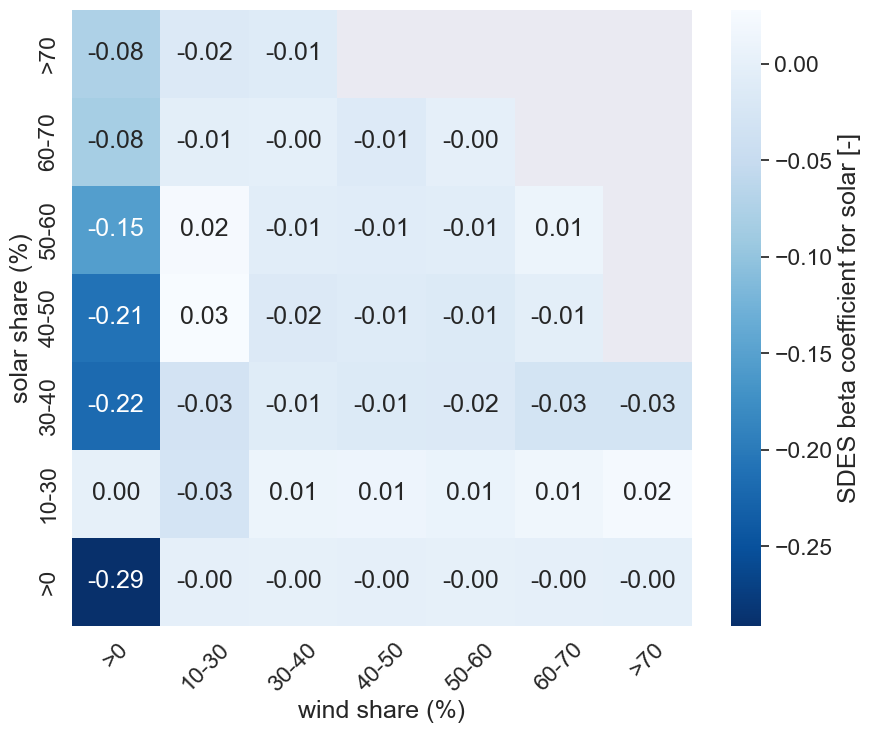

In [215]:
# color plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_beta_solar_SDES, annot=True, ax=ax, cmap="Blues_r", cbar_kws={'label': 'SDES beta coefficient for solar [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/beta_solar_SDES.png",dpi=300,bbox_inches="tight")


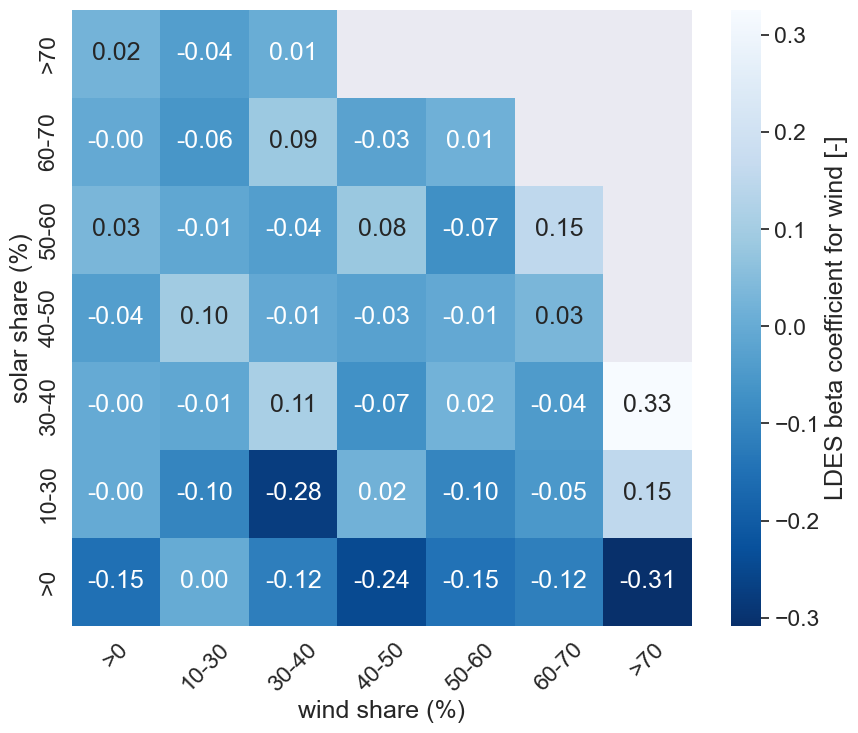

In [216]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_beta_wind_LDES, annot=True, ax=ax, cmap="Blues_r", cbar_kws={'label': 'LDES beta coefficient for wind [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/beta_wind_LDES.png",dpi=300,bbox_inches="tight")


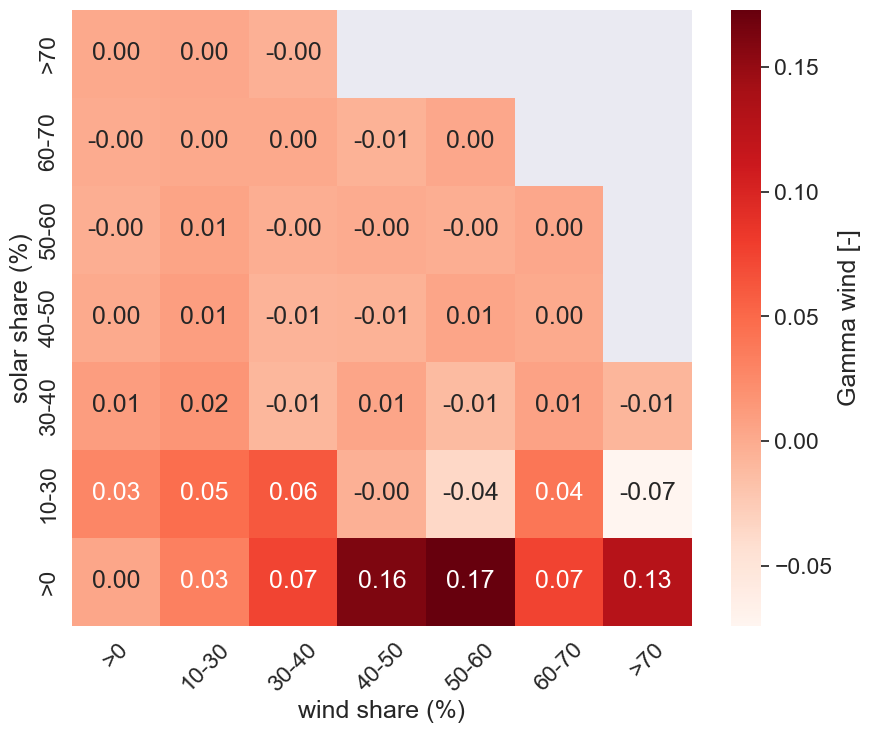

In [241]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_gamma_wind, annot=True, ax=ax, cmap="Reds", cbar_kws={'label': 'Gamma wind [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/gamma_wind.png",dpi=300,bbox_inches="tight")


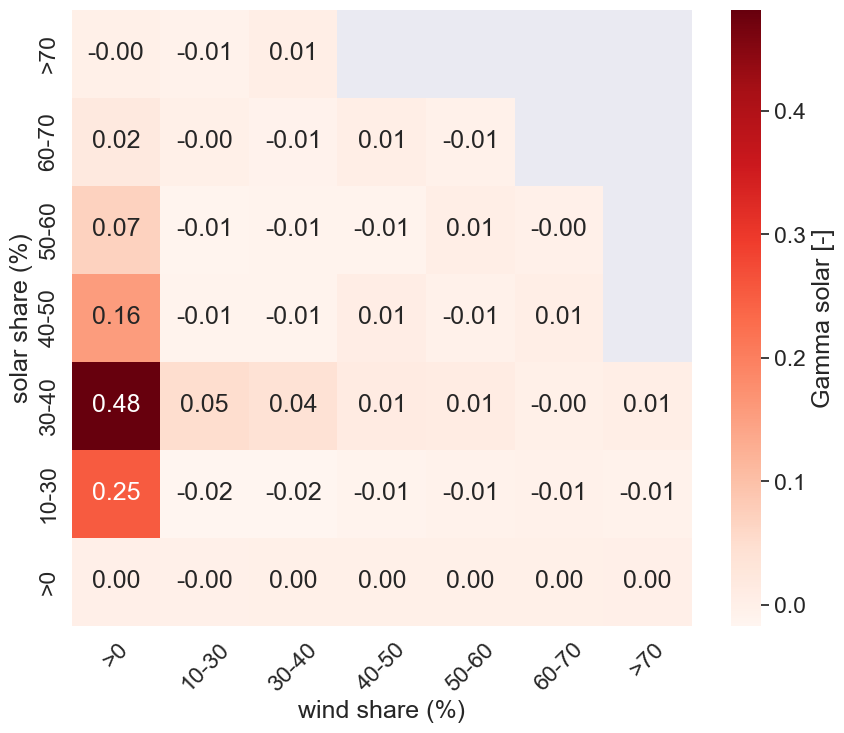

In [242]:
# color plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_gamma_solar, annot=True, ax=ax, cmap="Reds", cbar_kws={'label': 'Gamma solar [-]'},fmt='.2f')

ticklabels = [">0", "10-30", "30-40", "40-50", "50-60", "60-70", ">70"]
ax.set_xticks(np.arange(len(ticklabels))+0.5)
ax.set_xticklabels(ticklabels,rotation=45)
ax.set_yticks(np.arange(len(ticklabels))+0.5)

# change order of ticklabels
ticklabels = ticklabels[::-1]
ax.set_yticklabels(ticklabels)
ax.set_xlabel("wind share (%)",fontsize=18)
ax.set_ylabel("solar share (%)",fontsize=18)

plt.show()

fig.savefig("figures/gamma_solar.png",dpi=300,bbox_inches="tight")


### Step 2) load scenario in MESSAGEix-GLOBIOM

In [217]:
# load ixmp database
mp = ix.Platform('local',jvmargs=["-Xmx8G"])
solve_scenario = True # if True, solving scenario at the end
regions = ["R11_WEU", "R11_EEU"]

# reference scenario: 
opts = "remove_all_but_curtailment"
sc_ref = message_ix.Scenario(mp, 
                             model="MESSAGEix-GLOBIOM", 
                             scenario="ENGAGE_SSP2_EN_NPi2020_500_" + opts)

model = "MESSAGEix-GLOBIOM"
scen = "ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur_" + opts

# clone scenario and add modifications
sc = sc_ref.clone(model=model, scenario=scen, keep_solution=False)

sc.check_out()

years = sc.set('year')

# technology contributing to the curtailment relations that have not yet been parameterized from PyPSA-Eur scenarios
message_techs_in_curtailment_rels =  ["elec_trp",
                                        "h2_elec",
                                        "elec_exp_eurasia",
                                        "elec_imp_eurasia",
                                        "elec_exp_eur_afr",
                                        "elec_imp_eur_afr"]

if not replace_stor_ppl:
    message_techs_in_curtailment_rels += ["stor_ppl"]

technologies = {
    "solar": [x for x in set(sc_ref.set("technology")) if any([y in x for y in ["solar_res"]])], 
    "wind": [x for x in set(sc_ref.set("technology")) if any([y in x for y in ["wind_res", "wind_ref"]])], 
    "wind curtailed": [x for x in set(sc_ref.set("technology")) if "wind_curt" in x],
    "solar curtailed": [x for x in set(sc_ref.set("technology")) if "solar_curt" in x],
    }


# Convert retained technology contributions to new data structure

Keep beta coefficients from original representation in MESSAGEix-GLOBIOM for technologies that are not yet represented in the PyPSA-Eur linkage:

In [218]:
def keep_existing_tech_contributions(renewable,beta_tech_renewable):
    # interregional elcetricity flow (e.g., from Europe to North Africa) is something that we cannot 
    # represent in this softlinkage. For this reason, we want to keep the coefficients from the original
    # representation. We do this by first initializing the 2D array corresponding to the wind and solar 
    # bins used in PyPSA-Eur and then we copy the coefficients from the original representation to the
    # 2D array. This is only done for the first row in the array, corresponding to wind penetration without 
    # concurrent solar penetration (i.e., solar penetration = 0), to comply with the original representation.
    penetration_lvl_pypsa = {0:0,
                            1:10,
                            2:30,
                            3:40,
                            4:50,
                            5:60,
                            6:70}

    # Acquire parameters for the technology not included (yet) in the softlinkage
    tech_par = sc_ref.par("relation_activity",
                        filters={"relation": [renewable + "_curtailment_1",
                                                renewable + "_curtailment_2",
                                                renewable + "_curtailment_3"],
                                    "node_loc": ["R11_WEU"],
                                    "year_rel": [2020],
                                    "technology": message_techs_in_curtailment_rels,
                                    })

    # Parameters for the electricity demand defining the renewable penetration bins 
    elec_par = sc_ref.par("relation_activity",
                        filters={"relation": [renewable + "_curtailment_1",
                                                renewable + "_curtailment_2",
                                                renewable + "_curtailment_3"],
                                    "node_loc": ["R11_WEU"],
                                    "year_rel": [2020],
                                    "technology": ["elec_t_d"],
                                    })

    beta_tech = beta_tech_renewable["LDES"].copy()
    beta_tech.columns = ["beta"]
    beta_tech.loc[:,:] = 0
    solar_index = pd.Index([int(x.split("_")[2].split("s")[1].split("w")[0]) for x in beta_tech.index])
    wind_index = pd.Index([int(x.split("_")[2].split("w")[1].split("s")[0]) for x in beta_tech.index])
    beta_tech["wind_share"] = [penetration_lvl_pypsa[x] for x in wind_index]
    beta_tech["solar_share"] = [penetration_lvl_pypsa[x] for x in solar_index]

    beta_techs = {}
    for t in message_techs_in_curtailment_rels:
        tech_par_t = tech_par.query("technology == @t")
        beta_tech_insert = beta_tech.copy()

        penetration_lvl_message = (elec_par.value.abs()*100).to_list()
        beta_message = tech_par_t.value.to_list()

        secondary_index = solar_index if renewable == "wind" else wind_index

        for lvl in range(len(beta_message)):
            penetration_lvl_message_lvl = penetration_lvl_message[lvl]
            penetration_lvl_message_lvlp1 = penetration_lvl_message[lvl+1] if lvl < len(beta_message)-1 else 100
            
            index_lvl = beta_tech_insert.loc[secondary_index == 0].query(renewable + "_share > @penetration_lvl_message_lvl").query(renewable + "_share < @penetration_lvl_message_lvlp1").index
            
            if renewable == "wind":
                beta_tech_insert.loc[index_lvl,"beta"] = beta_message[lvl]
            else:
                beta_tech_insert.loc[index_lvl,"beta"] = sum(beta_message) # all bins in the existing MESSAGEix-GLOBIOM for solar PV belong to the same bin in the PyPSA-Eur data

        beta_tech_insert = beta_tech_insert.loc[beta_tech_insert.beta.drop_duplicates().index]
        beta_tech.loc[beta_tech_insert.index,"beta"] = beta_tech_insert

        beta_tech_t_df = pd.DataFrame(beta_tech.beta)
        beta_tech_t_df.columns = [0]

        # here, we try to shift the coefficients of the first bin in the original representation
        # this is because, the 0 coefficient in the first bin leads to very low VRE penetration
        if renewable == "wind":
            beta_tech_t_df.loc["wind_curtailment_w0s0"] = beta_tech_t_df.loc["wind_curtailment_w2s0"]
            beta_tech_t_df.loc["wind_curtailment_w2s0"] = 0
        elif renewable == "solar":
            beta_tech_t_df.loc["solar_curtailment_s0w0"] = beta_tech_t_df.loc["solar_curtailment_s2w0"]
            beta_tech_t_df.loc["solar_curtailment_s2w0"] = 0

        beta_techs[t] = beta_tech_t_df

        beta_tech_renewable_extended = beta_tech_renewable.copy()
        beta_tech_renewable_extended.update(beta_techs)

    return beta_tech_renewable_extended

In [219]:
def keep_existing_curtailment_rates(renewable):
    # gamma coefficients in the original representation
    gamma_old = sc_ref.par("input",
                            filters={"technology": [renewable + "_curtailment1",
                                                    renewable + "_curtailment2",
                                                    renewable + "_curtailment3"],
                                        "node_loc": ["R11_WEU"],
                                        "year_act": [2050],
                                        })[["technology","value"]]

    # penetration levels in the original representation
    elec_par = sc_ref.par("relation_activity",
                    filters={"relation": [renewable + "_curtailment_1",
                                            renewable + "_curtailment_2",
                                            renewable + "_curtailment_3"],
                                "node_loc": ["R11_WEU"],
                                "year_rel": [2020],
                                "technology": ["elec_t_d"],
                                })

    # penetration level in PyPSA-Eur
    penetration_lvl_pypsa = {0:0,
                            1:10,
                            2:30,
                            3:40,
                            4:50,
                            5:60,
                            6:70}

    if renewable == "wind":
        gamma_new = gamma_ij_wind.copy()
    elif renewable == "solar":
        gamma_new = gamma_ij_solar.copy()
    
    gamma_new.columns = ["gamma_coef"]
    gamma_new.loc[:,:] = 0
    solar_index = pd.Index([int(x.split("_")[2].split("s")[1].split("w")[0]) for x in gamma_new.index])
    wind_index = pd.Index([int(x.split("_")[2].split("w")[1].split("s")[0]) for x in gamma_new.index])
    gamma_new["wind_share"] = [penetration_lvl_pypsa[x] for x in wind_index]
    gamma_new["solar_share"] = [penetration_lvl_pypsa[x] for x in solar_index]        

    penetration_lvl_message = (elec_par.value.abs()*100).to_list()
    secondary_index = solar_index if renewable == "wind" else wind_index

    gamma_new_insert = gamma_new.copy()

    # print(gamma_new)
    for lvl in range(len(penetration_lvl_message)):
        penetration_lvl_message_lvl = penetration_lvl_message[lvl]
        penetration_lvl_message_lvlp1 = penetration_lvl_message[lvl+1] if lvl < len(penetration_lvl_message)-1 else 100
        # print(penetration_lvl_message_lvl)
        index_lvl = gamma_new.loc[secondary_index == 0].query(renewable + "_share > @penetration_lvl_message_lvl").query(renewable + "_share < @penetration_lvl_message_lvlp1").index

        if len(index_lvl) > 0:
            # print(index_lvl)
            index_lvl = index_lvl[0]

        if renewable == "wind":
            gamma_new_insert.loc[index_lvl,"gamma_coef"] = gamma_old.iloc[lvl].value
        else:
            gamma_new_insert.loc[index_lvl,"gamma_coef"] = sum(gamma_old.value) # all bins in the existing MESSAGEix-GLOBIOM for solar PV belong to the same bin in the PyPSA-Eur data

        # gamma_new_dict = gamma_new_insert.gamma_coef.to_dict()

    gamma_new = gamma_new_insert.drop(columns=["solar_share","wind_share"]
                               )
    gamma_new.columns = [0]
    
    return gamma_new

In [220]:
# as a first step in the evaluation of the softlink, we run a scenario where we are using the new structure 
# (splitting the curtailment relations into "VRE_curtailment_{ij}" and "wind_curtailment_{ij}" and 
# "solar_curtailment_{ij}" relations. Furthermore, it is using 6 x 6 bins for both wind and solar curtailment 
# instead of 1 x 3 bins.)
if keep_curtailment:
    gamma_ij_wind = keep_existing_curtailment_rates("wind")
    gamma_ij_solar = keep_existing_curtailment_rates("solar")

Make dictionary containing all beta coefficients, both the ones derived from PyPSA-Eur scenarios and the existing ones present in the original representation in MESSAGEix-GLOBIOM:

In [221]:
beta_tech_wind_extended = keep_existing_tech_contributions("wind",beta_tech_wind)
beta_tech_solar_extended = keep_existing_tech_contributions("solar",beta_tech_solar)

beta_dict = {}
for tech in beta_tech_wind_extended.keys():
    
    dict_w = beta_tech_wind_extended[tech].to_dict()
    beta_dict["wind", tech] = dict_w[list(dict_w.keys())[0]]

    dict_s = beta_tech_solar_extended[tech].to_dict()
    beta_dict["solar", tech] = dict_s[list(dict_s.keys())[0]]

In [222]:
if not replace_stor_ppl:
    beta_tech_wind_extended.pop("LDES") # remove "LDES" from beta_tech_wind_extended
    beta_tech_wind_extended.pop("SDES") # remove "SDES" from beta_tech_wind_extended

### Step 4) Technology linkage

Here, we replace the generic storage power plant "**stor_ppl**" with a short-duration and long-duration electricity storage (SDES and LDES). 

**LDES**
- duration (E/G_d): 50 hrs (variable)
- Efficiency (round-trip): 0.48
- Technology cost: 
    - Charge link: 450 EUR/kW (+ 2% FOM)
    - Storage: 12 EUR/kWh (+ 2% FOM)
    - Discharge link: 500 EUR/kW (+ 2% FOM) 
    
    Aggregated cost: 1/efficiency * 450 EUR/kW + duration * 12 EUR/kWh + 500 EUR/kW = 2,037.5 EUR/kW
- Capacity factor: 20.5% (variable)
- Lifetime: 20 years

**SDES**
- duration (E/G_d): 6 hrs (variable)
- Efficiency (round-trip): 0.94
- Technology cost: 
    - Charge link (battery inverter/converter): 160 EUR/kW
    - Storage: 142 EUR/kWh
    - Discharge link: 0 EUR/kW
    
    Aggregated cost: 1/effficiency * 160 EUR/kW + duration * 142 EUR/kWh + 0 EUR/kW = 1,022 EUR/kW
- Capacity factor: 11.9% (variable)
- Lifetime: 25 years


In MESSAGEix-GLOBIOM, the storage tech needs to have the following attributes defined:
- input electricity (par)
- output (par)
- inv_cost (par)
- technology (set)
- var_cost (par)
- technical_lifetime (par)
- capacity_factor (par)


Storage technology attributes from PyPSA-Eur:

In [223]:
# inputs
efficiency_ldes = 0.48 # round-trip efficiency of LDES
c_c_ldes = 450 # EUR/kW
c_hat_ldes = 12 # EUR/kWh
c_d_ldes = 500 # EUR/kW
ldes_lifetime = 20 # years

efficiency_sdes = 0.94 # round-trip efficiency of LDES
c_c_sdes = 160 # EUR/kW
c_hat_sdes = 142 # EUR/kWh
c_d_sdes = 0 # EUR/kW
sdes_lifetime = 25 # years

# read outputs from PyPSA-Eur concerning storage capacity and operation
path = "calculated_metrics/new_SDES_LDES_co2_lim/"

# duration (i.e., the ratio of energy capacity and discharge power capacity)
duration_ldes = pd.read_csv(path + "LDES_duration.csv",index_col=[0,1]) # LDES duration [hours]
duration_ldes_avg = duration_ldes.mean().item() # average over all wind-solar combinations 
duration_sdes = pd.read_csv(path + "SDES_duration.csv",index_col=[0,1]) # SDES duration [hours]
duration_sdes_avg = duration_sdes.mean().item() # average over all wind-solar combinations

# capacity factor (i.e., utilization rate of installed capacity)
ldes_capacity_factor = pd.read_csv(path + "LDES_capacity_factor.csv",index_col=[0,1]) # LDES CF [%]
ldes_capacity_factor_avg = ldes_capacity_factor[ldes_capacity_factor > 0].mean().item() # average over all wind-solar combinations
sdes_capacity_factor = pd.read_csv(path + "SDES_capacity_factor.csv",index_col=[0,1]) # LDES CF [%]
sdes_capacity_factor_avg = sdes_capacity_factor[sdes_capacity_factor > 0].mean().item() # average over all wind-solar combinations

# other features not used to calculate costs but relevant for comparison:
ldes_no_cycles = pd.read_csv(path + "LDES_no_cycles.csv",index_col=[0,1]) # LDES number of cycles
ldes_no_cycles_avg = ldes_no_cycles.mean().item() # average over all wind-solar combinations
sdes_no_cycles = pd.read_csv(path + "SDES_no_cycles.csv",index_col=[0,1]) # SDES number of cycles
sdes_no_cycles_avg = sdes_no_cycles.mean().item() # average over all wind-solar combinations
ldes_dod = pd.read_csv(path + "LDES_dod.csv",index_col=[0,1]) # LDES depth of discharge
ldes_dod_avg = ldes_dod.mean().item() # average over all wind-solar combinations
sdes_dod = pd.read_csv(path + "SDES_dod.csv",index_col=[0,1]) # SDES depth of discharge
sdes_dod_avg = sdes_dod.mean().item() # average over all wind-solar combinations

# aggregated cost:
ldes_inv_cost = 1/efficiency_ldes*c_c_ldes + duration_ldes*c_hat_ldes + c_d_ldes # EUR/kW
sdes_inv_cost = 1/efficiency_sdes*c_c_sdes + duration_sdes*c_hat_sdes + c_d_sdes # EUR/kW # 1022 # EUR/kW

ldes_inv_cost_avg = ldes_inv_cost.loc[ldes_capacity_factor[ldes_capacity_factor > 0].dropna().index].mean().item()
sdes_inv_cost_avg = sdes_inv_cost.loc[sdes_capacity_factor[sdes_capacity_factor > 0].dropna().index].mean().item()

Define pandas dataframes with storage attributes:

In [224]:
def add_storage_tech(tech, years, capacity_factor, inv_cost, lifetime, efficiency):

    df_input = make_df('input',
                       node_loc="R11_WEU",
                       technology= tech,
                       year_vtg=years,
                       year_act=years,
                       mode="M1",
                       node_origin="R11_WEU",
                       commodity="electr",
                       level="secondary",
                       time="year",
                       time_origin="year",
                       value = efficiency,
                       unit = "GWa")

    df_output = make_df('output',
                            node_loc = "R11_WEU",
                            technology = tech,
                            year_vtg = years,
                            year_act = years,
                            mode = "M1",
                            node_dest = 'R11_WEU',
                            commodity = 'exports',
                            level = "secondary",
                            time = "year",
                            time_dest = "year",
                            value = 1,
                            unit = "GWa",
                            )

    df_CF = make_df('capacity_factor',
                            node_loc = "R11_WEU",
                            technology = tech,
                            year_vtg = years,
                            year_act = years,
                            time = "year",
                            value = capacity_factor,
                            unit = "%",
                            )

    df_inv_cost = make_df('inv_cost',
                            node_loc="R11_WEU",
                            technology=tech,
                            year_vtg=years,
                            value=inv_cost,
                            unit="USD/GWa",
                            )

    df_lifetime = make_df('technical_lifetime',
                            node_loc="R11_WEU",
                            technology=tech,
                            year_vtg=years,
                            value=lifetime,
                            unit="y")
    

    # Now that we have added the LDES and SDES as technologies in the scenario, 
    # we also need to define their parameters in the VRE integration constraints. 
    # Here, we add the parameters for LDES and SDES to the firm capacity constraint
    # and the flexibility constraint. We assume the storage is fully contributing to
    # the firm capacity constraint and the flexibility constraint, i.e., they have 
    # values of 1.0 (which is the same value for stor_ppl):
    
    # firm capacity constraint
    df_res_marg = make_df('relation_total_capacity',
                          relation = "res_marg",
                          node_rel = "R11_WEU",
                          year_rel = years,
                          technology = tech,
                          value = 1.0,
                          unit = "???"
                          )
    
    # flexibility constraint
    df_oper_res = make_df('relation_activity',
                          relation = "oper_res",
                          node_rel = "R11_WEU",
                          year_rel = years,
                          node_loc = "R11_WEU",
                          technology = tech,
                          year_act = years,
                          mode = "M1",
                          value = 1.0,
                          unit = "???"
                          )
    
    sc.add_set("technology", tech)
    sc.add_par('input',df_input)
    sc.add_par('output',df_output)
    sc.add_par("capacity_factor", df_CF)
    sc.add_par('inv_cost',df_inv_cost)
    sc.add_par('technical_lifetime',df_lifetime)
    sc.add_par('relation_total_capacity',df_res_marg)
    sc.add_par("relation_activity",df_oper_res)
    
    # sc.idx_names('capacity_factor')

Add storage technologies to the scenario:

In [225]:
if replace_stor_ppl:
    add_storage_tech("LDES", years, ldes_capacity_factor_avg, ldes_inv_cost_avg, ldes_lifetime, efficiency_ldes)
    add_storage_tech("SDES", years, sdes_capacity_factor_avg, sdes_inv_cost_avg, sdes_lifetime, efficiency_sdes)

Now that we have added LDES and SDES as technologies and copied the parameters from the firm capacity and flexibility constraints for stor_ppl (only in Western Europe), we will remove "*stor_ppl*" from these two constraints:

In [226]:
if replace_stor_ppl:
    # Removing "stor_ppl" from the firm capacity constraint (res_marg)
    df_res_marg = sc.par("relation_total_capacity", 
                        {"relation":"res_marg",
                        "technology":"stor_ppl",
                        "node_rel":"R11_WEU"})
    sc.remove_par("relation_total_capacity", df_res_marg)

    # Removing "stor_ppl" from the flexibility constraint (oper_res)
    df_oper_res = sc.par("relation_activity", 
                        {"relation":"oper_res",
                        "technology":"stor_ppl",
                        "node_rel":"R11_WEU"})
    sc.remove_par("relation_activity", df_oper_res)

### Step 5) Add curtailment technologies and relations to the scenario

Initialize curtailment relations:

In [227]:
# number of bins (determined from the PyPSA-Eur data):
bins = list(set(renewable_penetration_dict.values()))
bins.sort()

bins_dict = {}
curt_relation = {} # i = solar, j = wind
curt_relation_tech = {}
new_bins = {}
prefix = "vre" # prefix of relation name
for i in range(len(bins)): # wind index
    for j in range(len(bins)): # solar index
        
        w = "wind_curtailment_w" + str(i) + "s" + str(j) # index naming in the data achieved from PyPSA-Eur
        s = "solar_curtailment_s" + str(j) + "w" + str(i) # index naming in the data achieved from PyPSA-Eur

        wind_curt_name = "wind_curtailment" + str(i+1) # naming of wind curtailment technology in MESSAGEix-GLOBIOM
        solar_curt_name = "solar_curtailment" + str(j+1) # naming of solar curtailment technology in MESSAGEix-GLOBIOM
        # for naming convenience, we shift the index naming by one such that the first bin starts at index = 1

        if (w not in gamma_ij_wind.index) and (s not in gamma_ij_solar.index): 
            continue
        
        # technology parameters from PyPSA-Eur
        LDES_tech_term = beta_dict["wind","LDES"][w] + beta_dict["solar","LDES"][s]
        SDES_tech_term = beta_dict["wind","SDES"][w] + beta_dict["solar","SDES"][s]
        
        # keeping technology parameters from original MESSAGEix-GLOBIOM representation
        EV_tech_term = beta_dict["wind","elec_trp"][w] + beta_dict["solar","elec_trp"][s]
        h2_tech_term = beta_dict["wind","h2_elec"][w] + beta_dict["solar","h2_elec"][s]
        exp_tech_term = beta_dict["wind","elec_exp_eurasia"][w] + beta_dict["solar","elec_exp_eurasia"][s]
        imp_tech_term = beta_dict["wind","elec_imp_eurasia"][w] + beta_dict["solar","elec_imp_eurasia"][s]

        new_bins[prefix + "_curtailment_w" + str(i+1) + "s" + str(j+1)] = [wind_curt_name, solar_curt_name]
        
        rel_dict = {wind_curt_name:gamma_ij_wind.loc[w].item(),
                    solar_curt_name:gamma_ij_solar.loc[s].item(),
                    "elec_trp":EV_tech_term,
                    "h2_elec":h2_tech_term,
                    "elec_exp_eurasia":exp_tech_term,
                    "elec_imp_eurasia":imp_tech_term,
                    "elec_exp_eur_afr":exp_tech_term,
                    "elec_imp_eur_afr":imp_tech_term,
                    }
        
        if replace_stor_ppl:
            rel_dict.update({"LDES":LDES_tech_term,
                            "SDES":SDES_tech_term})
            
        else:
            stor_ppl_tech_term = beta_dict["wind","stor_ppl"][w] + beta_dict["solar","stor_ppl"][s]
            rel_dict.update({"stor_ppl":stor_ppl_tech_term})

        curt_relation[prefix + "_curtailment_w" + str(i+1) + "s" + str(j+1)] = [rel_dict]
        
        if j == 0:
            curt_relation_tech["wind_curtailment_" + str(i+1)] = wind_curt_name
            bins_dict["wind_curtailment_" + str(i+1)] = bins[i]
        
        if i == 0:
            curt_relation_tech["solar_curtailment_" + str(j+1)] = solar_curt_name
            bins_dict["solar_curtailment_" + str(j+1)] = bins[j]

curt_relation_tech = {k: curt_relation_tech[k] for k in sorted(curt_relation_tech)}

# print first five entries of the dictionaries
print({k: curt_relation[k] for k in list(curt_relation)[:5]})
print({k: curt_relation_tech[k] for k in list(curt_relation_tech)[:5]})

{'vre_curtailment_w1s1': [{'wind_curtailment1': 0.0, 'solar_curtailment1': 0.0, 'elec_trp': -0.31666, 'h2_elec': -0.8736842105263158, 'elec_exp_eurasia': -0.76, 'elec_imp_eurasia': 0.76, 'elec_exp_eur_afr': -0.76, 'elec_imp_eur_afr': 0.76, 'stor_ppl': -3.3200000000000003}], 'vre_curtailment_w1s2': [{'wind_curtailment1': 0.0, 'solar_curtailment2': 0.0, 'elec_trp': 0.0, 'h2_elec': 0.0, 'elec_exp_eurasia': 0.0, 'elec_imp_eurasia': 0.0, 'elec_exp_eur_afr': 0.0, 'elec_imp_eur_afr': 0.0, 'stor_ppl': 0.0}], 'vre_curtailment_w1s3': [{'wind_curtailment1': 0.0, 'solar_curtailment3': 0.75, 'elec_trp': 0.0, 'h2_elec': 0.0, 'elec_exp_eurasia': 0.0, 'elec_imp_eurasia': 0.0, 'elec_exp_eur_afr': 0.0, 'elec_imp_eur_afr': 0.0, 'stor_ppl': 0.0}], 'vre_curtailment_w1s4': [{'wind_curtailment1': 0.0, 'solar_curtailment4': 0.0, 'elec_trp': 0.0, 'h2_elec': 0.0, 'elec_exp_eurasia': 0.0, 'elec_imp_eurasia': 0.0, 'elec_exp_eur_afr': 0.0, 'elec_imp_eur_afr': 0.0, 'stor_ppl': 0.0}], 'vre_curtailment_w1s5': [{'wind

In [228]:
# Curtailment relations and technologies (for checking)
curtail_relations = [x for x in set(sc.set("relation")) if "curtailment" in x]
curtail_techs = [x for x in set(sc.set("technology")) if "curtailment" in x]

# Add wind/solar curtailment data for new bins (not present in the old data)
new_relations = [x for x in bins_dict.keys() if x not in set(sc.set("relation"))]
new_techs = [curt_relation_tech[x] for x in new_relations]

# Add new set elements to the scenario
sc.add_set("technology", new_techs) # here, new technologies cover the ones for "wind_curtailment_{}" and "solar_curtailment_{}".
sc.add_set("relation", new_relations) # here, new relations cover the ones for "wind_curtailment_{}" and "solar_curtailment_{}".

print("Added new technologies: ", new_techs)
print("Added new relations: ", new_relations)

Added new technologies:  ['solar_curtailment4', 'solar_curtailment5', 'solar_curtailment6', 'solar_curtailment7', 'wind_curtailment4', 'wind_curtailment5', 'wind_curtailment6', 'wind_curtailment7']
Added new relations:  ['solar_curtailment_4', 'solar_curtailment_5', 'solar_curtailment_6', 'solar_curtailment_7', 'wind_curtailment_4', 'wind_curtailment_5', 'wind_curtailment_6', 'wind_curtailment_7']


In [229]:
# In this step, we add the parameters representing the base curtailment, i.e., we don't yet 
# consider the role of curtailment-reducing technologies like storage etc.
parname = "relation_activity"
for rel, region in product(sorted(bins_dict.keys()), regions):
    
    # renewable name (wind or solar)
    renewable = rel.split("_")[0]
    # curtailment technology name (e.g., "wind_curtailment_1")
    curtail_tec = curt_relation_tech[rel]

    # Load existing data (and use it later for configuring the new data)
    old = sc_ref.par(parname, {"node_loc": region, 
                               "relation": renewable + "_curtailment_1"})
    
    # Generate theoretical curtailment bins (with contributor technologies, but
    # these will be removed at the end)
    new = old.copy()
    new.relation = rel
    new.technology.replace({renewable + "_curtailment1":curtail_tec},inplace=True)
    # Edit the % share of wind/solar bins (Notice (-) sign)
    new.loc[new.query("technology == 'elec_t_d'").index,"value"] = -bins_dict[rel]

    # Add theoretical curtailment to the scenario
    sc.add_par(parname, new)

    # Add an upper bound for the theoretical curtailment (needed for new bins)
    bound = new.drop_duplicates(["node_rel", "year_rel", "relation"]).copy()
    bound["value"] = 0
    sc.add_par("relation_upper", bound)

    # Update the data of "input" electricity for this curtailment technology
    inp_old = sc.par("input", {"node_loc": region, 
                           "technology": renewable + "_curtailment1"})
    
    inp_new = inp_old.copy()
    inp_new.technology = curt_relation_tech[rel] # is needed in case a new bin is added
    inp_new.value = 1 # Note that this is different compared to the old approach. The gamma coefficients are added later.
    sc.add_par("input", inp_new)

print("- New theoretical curtailment relations configured.")

- New theoretical curtailment relations configured.


In [230]:
# remove technology contributions from base curtailment relations
for region in regions:
    df_tech_contrib = sc.par("relation_activity",
                            {"node_loc": region,
                            "relation": curt_relation_tech.keys(),
                            "technology": message_techs_in_curtailment_rels})

    sc.remove_par("relation_activity",df_tech_contrib)

Add new bins to the set of relations and new technologies to technology in the scenario:

In [231]:
sc.add_set("relation", new_bins.keys())

for rel_new, region in product(sorted(new_bins.keys()), regions):
    # Relevant wind/solar relations
    relations = [x for x, y in curt_relation_tech.items() if y in new_bins[rel_new]]

    old = sc.par(parname, {"node_loc": region, 
                           "relation": relations})
    if old.empty:
        continue

    # Keep only contributor and curtailment technologies
    # This does not need VRE generation and electricity grid, as the curtailment
    # bins as % of the grid were calculated in step (3) and here we use them
    techs = [x for x in set(old["technology"]) if
             not any([y in x for y in ["wind_r", "solar_r", "elec_t_d"]])]
    
    new = old.loc[old["technology"].isin(techs)].copy()

    # Group technology contributions across wind and solar relations. 
    # This is done by taking the sum of contribution values for solar and
    # wind for the considered VRE bin (e.g., if storage has 0.2 for wind, 0.1 for solar,
    # sum(0.2 , 0.1) = 0.3 will be used for this VRE bin)
    new = new.groupby(
        ["node_rel", "node_loc", "mode", "technology", "year_rel", "year_act"]
                      ).sum(numeric_only=True)
    new = new.assign(relation=rel_new, unit="GWa").reset_index()

    # insert value
    new.loc[new["technology"].isin(new_bins[rel_new]), "value"] = 1
    for t in curt_relation[rel_new][0].keys():
        new_ind = new.query("technology == @t").index

        if len(new_ind) > 0:
            new.loc[new_ind,"value"] = curt_relation[rel_new][0][t]
        else:
            df = make_df("relation_activity",
                        relation=rel_new,
                        node_rel="R11_WEU",
                        year_rel=years,
                        node_loc="R11_WEU",
                        technology=t,
                        year_act=years,
                        mode = "M1",
                        value = curt_relation[rel_new][0][t],
                        unit = "???")
        
            sc.add_par("relation_activity", df)

    # Add the new equation for the VRE curtailment bin to the scenario
    sc.add_par(parname, new)

    # Add an upper bound for the new relation
    bound = new.drop_duplicates(["node_rel", "year_rel", "relation"]).copy()
    bound["value"] = 0
    sc.add_par("relation_upper", bound)

    # If treating input electricity at the VRE level (combination of solar-wind bins)
    
    # Relevant VRE technology
    tech_new = ("_").join(rel_new.split("_")[:2]) + rel_new.split("_")[2]
    
    # Add new VRE technology to the scenario
    sc.add_set("technology", tech_new)
    
    # Add VRE technology to this curtailment relation
    vre = new.loc[new["technology"].isin(new_bins[rel_new])]
    
    # Change the sign of VRE curtailment value to (-)
    # VRE curtailment is equal to the unmet curtailment of wind and solar, i.e.:
    # wind_curtail + solar_curtail <= storage (all contributors) + VRE_curtail
    vre = vre.assign(technology=tech_new, 
                     value=-1)
    
    sc.add_par(parname, vre)

    # Add "input" electricity for this VRE technology
    # Load sample data and copy it for each bin
    # if include_vre_input_loss:
    inp = sc.par("input", {"node_loc": regions,
                            "technology": "solar_curtailment1"})
    
    # Add input values for curtailed electricity at each combination of wind and solar
    inp = inp.assign(technology=tech_new, 
                        value=1)
    
    sc.add_par("input", inp)

print("- New VRE curtailment relations configured.")


- New VRE curtailment relations configured.


Remove the contribution from stor_ppl as it has been replaced by LDES and SDES:

In [232]:
for region in regions:
    df = sc.par("relation_activity",
                {"node_loc": region, 
                "technology": "stor_ppl"})

    sc.remove_par("relation_activity", df)

In [233]:
sc.commit("Curtailment updated")

### 6. Solve scenario

In [234]:
if solve_scenario:
    #case = sc.model + '__' + sc.scenario + '__v' + str(sc.version)
    print(f'Solving scenario "{scen}", please wait...!')

    start = timer()
#     sc.solve(model='MESSAGE', case=case)
    sc.solve(solve_options={"lpmethod": "4",
                            "advind":"0",
                            "lpmethod":"4","threads":"4", 
                            "epopt":"1e-06",
                            "scaind":"-1"})

    end = timer()
    print('Elapsed time for solving scenario:', int((end - start)/60),
          'min and', round((end - start) % 60, 2), 'sec.')
    sc.set_as_default()

Solving scenario "ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur_remove_all_but_curtailment", please wait...!
Elapsed time for solving scenario: 170 min and 26.72 sec.


In [235]:
mp.close_db()